# Youtube Data API

In [ ]:
!pip install google-api-python-client

In [7]:
import json
from googleapiclient.discovery import build

In [8]:
DEVELOPER_KEY = json.load(open('./keys/youtube_key.json'))['api_key']
YOUTUBE_API_SERVICE_NAME = 'youtube'
YOUTUBE_API_VERSION = 'v3'

youtube = build(
    YOUTUBE_API_SERVICE_NAME,
    YOUTUBE_API_VERSION,
    developerKey=DEVELOPER_KEY
)


In [9]:
# Get Channel object

# 1. First find Channel ID by Channel Name

request = youtube.search().list(
        part="snippet",
        maxResults=5,
        q="Barbascura eXtra",
        type="channel"
    )

response = request.execute()

channelId = response['items'][0]['id']['channelId']

channelId

'UCHi6Q3Z-5oJUC691WLlSntA'

In [10]:
# 2. Then fetch the information we need about it

request = youtube.channels().list(
    part="snippet,contentDetails",
    id= channelId
    )
response = request.execute()
uploaded_playlist = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
uploaded_playlist

'UUHi6Q3Z-5oJUC691WLlSntA'

In [11]:
channel_videos : list = list()

page_token = None

while True:
    request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            maxResults=50,
            playlistId=uploaded_playlist,
            pageToken = page_token
    )

    response = request.execute()

    channel_videos.extend(
        v['contentDetails']['videoId']
        for v in response['items']
    )

    if response.get('nextPageToken', None) is None:
        break

    page_token = response['nextPageToken']

len(channel_videos)

379

In [40]:
import time

# Get Comments for Every Video
commentators : dict[str, set[str]] = {}

for video_id in channel_videos[:100]:

    page_token = None

    video_commentators : set = set()

    while True:
        request = youtube.commentThreads().list(
            part="snippet",
            videoId=video_id,
            maxResults=100,
            pageToken = page_token
        )

        response = request.execute()

        video_commentators.update(
            ct['snippet']['topLevelComment']['snippet']['authorDisplayName']
            for ct in response['items']
        )

        if response.get('nextPageToken', None) is None:
            break

        page_token = response['nextPageToken']

    time.sleep(0.1)
    commentators[video_id] = video_commentators


In [41]:
len(commentators)

100

In [55]:
# Now use networkx to create a Network:
#   * Nodes are the Videos
#   * The Edge (a, b) is present if a and b share some commentators

In [42]:
# Write Weighted Edge List to a File

nodes_list = list(commentators.keys())
edges_list = []

for i in range(0, len(nodes_list)):
    video1 = nodes_list[i]
    for j in range(i+1, len(nodes_list)):
        video2 = nodes_list[j]

        common_commentators = commentators[video1] & commentators[video2]

        if len(common_commentators) > 0:
            edges_list.append((video1, video2, len(common_commentators)))


with open('data/barbascurax_commenters.edges', 'w') as f:
    f.write('\n'.join("%s %s %d" % edge for edge in edges_list))


In [51]:
# Build the Network

import networkx as nx

G = nx.read_weighted_edgelist(
    'data/barbascurax_commenters.edges',
)

G.order(), G.size()

(100, 4803)

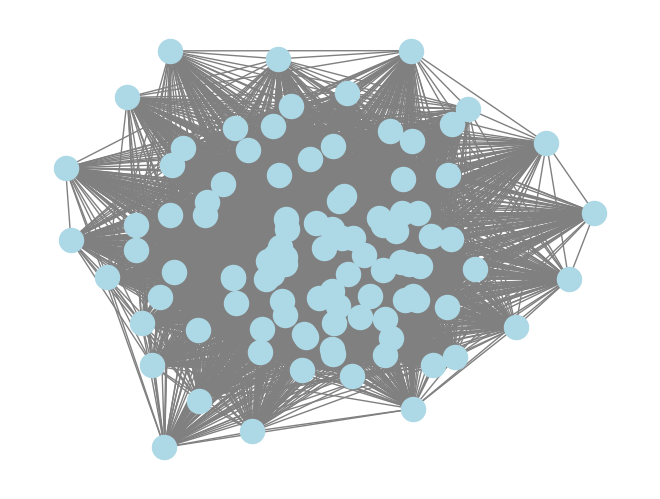

In [53]:
# Draw the Network

pos=nx.spring_layout(G)

nx.draw(
    G,
    pos=pos,
    node_color="lightblue",
    edge_color="gray"
)